| ISS Tracker | International Space Station Tracker  |
| ----------- | ----------- |
| ISS API url | http://api.open-notify.org/ |

In [113]:
# libraries
import requests
import pandas as pd
import numpy as np
import folium #maps
import datetime
# from datetime import datetime
import reverse_geocoder as rg #turns gps coords into readable names
import pycountry #gets country flags
from IPython.display import Image, display
import time
from pytrends.request import TrendReq
import matplotlib.pyplot as plt
import matplotlib
from IPython.display import Image
from IPython.display import clear_output
from tqdm.notebook import tqdm, trange

In [114]:
"""GET names of astros on-board the ISS"""

# r = requests.get(url='http://api.open-notify.org/astros.json')
# r.json()

# determine the astronaughts, cosmonaughts, etc. that are currently onboard the ISS
astros_url = 'http://api.open-notify.org/astros.json'
astros_response = requests.get(astros_url)
astros_data = astros_response.json()
# print(astros_data)

# print the astros that are onboard the ISS craft
print("Number of people currently aboard the ISS:", astros_data['number'])
print("\nNames of people aboard the ISS:")

for i in astros_data['people']:
    print(i['name'])

Number of people currently aboard the ISS: 10

Names of people aboard the ISS:
Sergey Prokopyev
Dmitry Petelin
Frank Rubio
Fei Junlong
Deng Qingming
Zhang Lu
Stephen Bowen
Warren Hoburg
Sultan Alneyadi
Andrey Fedyaev


In [115]:
"""GET the current location of the ISS"""

# send a GET request to the ISS API endpoint
iss_loc_response = requests.get("http://api.open-notify.org/iss-now.json")
iss_loc_data = (iss_loc_response.json())
# print the API parameters
# print(iss_loc_data)

# extract the latitude and longitude for the current location of the ISS
time_stamp = iss_loc_data['timestamp']
iss_lat = float(iss_loc_data['iss_position']['latitude']) # also, converts lat string to float
iss_long = float(iss_loc_data['iss_position']['longitude']) # also, converts long string to float

# print the current latitude and longitude for the ISS
print(f"Timestamp: {time_stamp}")
print()
print("Current ISS Location:")
print(f"Latitude: {iss_lat}")
print(f"Longitude: {iss_long}")

Timestamp: 1681835776

Current ISS Location:
Latitude: 37.5956
Longitude: -154.6463


In [116]:
# find the nearest country using reverse_geocoder
coordinates = (iss_lat, iss_long)
results = rg.search(coordinates)
# print(results)

# print the nearest country
city = results[0]['name']
state_provence = results[0]['admin1']
country_code = results[0]['cc']

# convert country code to full country name
country = pycountry.countries.get(alpha_2=country_code)
country_name = country.name

print()
print(f"Nearest country: {city}, {state_provence}, {country_code}")
print(f"Country Code: {country_code} = {country_name}")

# display the country flag based on the country code
flag_url = f"https://flagcdn.com/w320/{country_code.lower()}.png"
display(Image(url=flag_url))


Nearest country: Kilauea, Hawaii, US
Country Code: US = United States



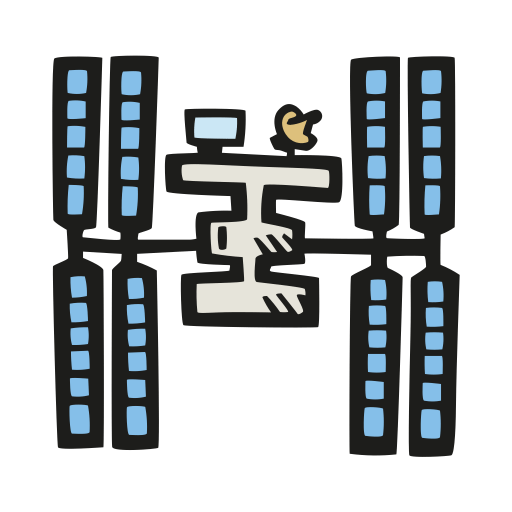

In [117]:
# create a map centered on teh ISS's current location
map_a = folium.Map(location=[iss_lat,iss_long], tiles='stamentoner', zoom_start=4)

# create a custom icon
icon = folium.features.CustomIcon('iss_icon.png', icon_size=(44,44))

# create a popup with the names of the astronauts onboard
popup_text = "Astronauts onboard the ISS:<br>"
for i in astros_data['people']:
    popup_text += f"{i['name']}<br>"
popup = folium.Popup(popup_text, max_width=250)

# Add marker to map with custom icon and popup
folium.Marker([iss_lat, iss_long], icon=icon, popup=popup).add_to(map_a)

# display map
display(map_a) # map_a -> stands for 'map astros'

In [118]:
# # this is for TESTING, comment out so the variables don't overwrite
# # look at an example of the unique timestamp (you can use this as your unique time KEY)
# date_save_as = datetime.datetime.now().strftime("%Y%m%d%H%M%S") # this defaults to your computers time.
# print(f"The time right now is: {date_save_as}") # you will use this later to save your output to a csv file

| Data Collection ON/OFF Switch | w/ True/False |
|----------------------|----------------------------------------------|
| ISS Space Station Data Collection | Toggle real-time data recording
| record_data_ON = False| record_data_ON = True| 


In [119]:
record_data_ON = False # manually toggle this True / False
if record_data_ON == True:
    date_save_as = datetime.datetime.now().strftime("%Y%m%d%H%M%S")
    starttime = time.time()

    iss_rt_tracking_data = []
    counter = 1  # initialize the counter variable

    while True:
        iss_loc_response = requests.get("http://api.open-notify.org/iss-now.json")
        iss_loc_data = iss_loc_response.json()
        print(f"Round {counter}: {iss_loc_data}")  # print the counter value and the data

        iss_rt_tracking_data.append([iss_loc_data['timestamp'],
                                     iss_loc_data['iss_position']['latitude'],
                                     iss_loc_data['iss_position']['longitude']
                                     ])

        # dump data to csv file
        dump_cols = ['time_stamp', 'lat', 'long']
        tmp_iss_df = pd.DataFrame(iss_rt_tracking_data, columns=dump_cols)
        tmp_iss_df.to_csv('ISS_location_' + date_save_as + '.csv', index=None)

        # save the file name to a var so that later I can call it with read_csv()
        iss_flight_record_file = 'iss_location_' + date_save_as + '.csv'

        # increment the counter variable
        counter += 1

        # collect 10mins of data
        # if len(iss_rt_tracking_data) > 10: # 10mins (11 rounds starting from zero)
        #     break

        # if len(iss_rt_tracking_data) > 60: # 60mins (61 rounds starting from zero)
        #     break

        if len(iss_rt_tracking_data) > 90: # 90mins (91 rounds starting from zero)
            break

        # safety break
        # if len(iss_rt_tracking_data) > 18000:
        #     break

        # set sleep timer -> will record one data point every minute (60 seconds) or whatever you adjust it to
        time.sleep(60.0 - ((time.time()-starttime) % 60.0))


In [120]:
# verfify file name string
iss_flight_record_file = 'ISS_location_' + date_save_as + '.csv'
print(iss_flight_record_file)
print(type(iss_flight_record_file))

ISS_location_20230415084451.csv
<class 'str'>


In [121]:
# load historical data
iss_flight_record = pd.read_csv(iss_flight_record_file)

# print(iss_flight_record)
print(iss_flight_record.tail())
print(iss_flight_record.shape)

# # Get the number of rows in the DataFrame
# num_rows = iss_flight_record.shape[0]
# # Calculate the midpoint index
# midpoint = num_rows // 2
# # Slice the data and print 10 rows from the middle
# print(iss_flight_record.iloc[midpoint-5:midpoint+5])


    time_stamp      lat      long
86  1681578771   2.3477  178.1523
87  1681578831   5.3842 -179.6819
88  1681578891   8.4112 -177.4918
89  1681578951  11.3982 -175.2816
90  1681579011  14.3893 -172.9999
(91, 3)


In [122]:
"""
The timestamp 1678990112 represents a specific point in time, 
measured in seconds since the Unix epoch, which is January 1, 1970, 00:00:00 UTC
"""
# test list comprehension
# [d for d in iss_flight_record['time_stamp']]

'\nThe timestamp 1678990112 represents a specific point in time, \nmeasured in seconds since the Unix epoch, which is January 1, 1970, 00:00:00 UTC\n'

In [123]:
# re-import this function to get the fromtimestamp()function
from datetime import datetime

"""
Convert thetimestamp to a datetime object using the datetime library, 
to determine the exact date and time that it corresponds to
"""
date_time = [datetime.fromtimestamp(dt) for dt in iss_flight_record['time_stamp']]

# date_time

# pass date_time back to the original df as a new feature called 'date'
iss_flight_record['date'] = date_time

# add a plot size from oldest to newest
iss_flight_record['index'] = range(1,len(iss_flight_record)+1)

# look at the df
iss_flight_record.head(10)

,time_stamp,lat,long,date,index
0,1681573491,16.9094,-147.4130,2023-04-15 08:44:51,1
1,1681573551,19.8444,-144.9908,2023-04-15 08:45:51,2
2,1681573611,22.7145,-142.4895,2023-04-15 08:46:51,3
3,1681573671,25.5589,-139.8487,2023-04-15 08:47:51,4
4,1681573731,28.3442,-137.0679,2023-04-15 08:48:51,5
5,1681573791,31.0589,-134.1255,2023-04-15 08:49:51,6
6,1681573851,33.6903,-130.9981,2023-04-15 08:50:51,7
7,1681573911,36.2239,-127.6609,2023-04-15 08:51:51,8
8,1681573971,38.6240,-124.1189,2023-04-15 08:52:51,9
9,1681574031,40.9118,-120.2882,2023-04-15 08:53:51,10


In [124]:
# reorder the df columns 
iss_fr_df_cols = ['index','time_stamp','date','lat','long']
iss_fr_df = iss_flight_record.reindex(columns=iss_fr_df_cols)

iss_fr_df.tail(10)

,index,time_stamp,date,lat,long
81,82,1681578471,2023-04-15 10:07:51,-12.7591,167.2297
82,83,1681578531,2023-04-15 10:08:51,-9.7577,169.4788
83,84,1681578591,2023-04-15 10:09:51,-6.7380,171.6834
84,85,1681578651,2023-04-15 10:10:51,-3.7312,173.8396
85,86,1681578711,2023-04-15 10:11:51,-0.6924,175.9975
86,87,1681578771,2023-04-15 10:12:51,2.3477,178.1523
87,88,1681578831,2023-04-15 10:13:51,5.3842,-179.6819
88,89,1681578891,2023-04-15 10:14:51,8.4112,-177.4918
89,90,1681578951,2023-04-15 10:15:51,11.3982,-175.2816
90,91,1681579011,2023-04-15 10:16:51,14.3893,-172.9999


In [125]:
# extract 'lat' and 'long' columns and create a list of tuples
data_points = list(zip(iss_fr_df['lat'], iss_fr_df['long']))

# print 10 data points per line -> looks cleaner with 10 data points per line
for i in range(0, len(data_points), 10):
    print(data_points[i:i+10])

[(16.9094, -147.413), (19.8444, -144.9908), (22.7145, -142.4895), (25.5589, -139.8487), (28.3442, -137.0679), (31.0589, -134.1255), (33.6903, -130.9981), (36.2239, -127.6609), (38.624, -124.1189), (40.9118, -120.2882)]
[(43.0456, -116.1746), (45.0019, -111.7593), (46.7551, -107.0312), (48.2666, -102.034), (49.535, -96.6987), (50.5209, -91.0991), (51.2044, -85.259), (51.5625, -79.3095), (51.5899, -73.3061), (51.2896, -67.39)]
[(50.6642, -61.5474), (49.7303, -55.9033), (48.5093, -50.5147), (47.0261, -45.4188), (45.3078, -40.6338), (43.3981, -36.198), (41.2906, -32.0278), (39.0246, -28.1445), (36.6216, -24.5257), (34.1008, -21.1463)]
[(31.5014, -18.0067), (28.7945, -15.0295), (26.0148, -12.218), (23.1734, -9.5501), (20.2805, -7.0049), (17.3446, -4.563), (14.3988, -2.226), (11.4009, 0.0617), (8.3814, 2.2962), (5.347, 4.4919)]
[(2.3033, 6.6631), (-0.7187, 8.8056), (-3.7648, 10.9694), (-6.8037, 13.1498), (-9.8302, 15.3611), (-12.8379, 17.6173), (-20.6463, 23.9101), (-21.6608, 24.7917), (-24.


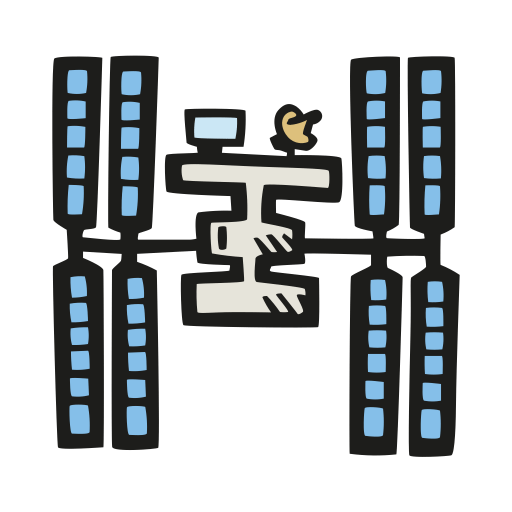

In [126]:
# plot the ISS flight path on a map
# find the center of the data points for the initial map view
avg_lat = sum([point[0] for point in data_points]) / len(data_points)
avg_long = sum([point[1] for point in data_points]) / len(data_points)

# create a folium Map instance
map_fr = folium.Map(location=[avg_lat, avg_long], tiles='CartoDB dark_matter', zoom_start=2.75)

# add data points to the map
for index, point in enumerate(data_points, start=1):
    if index == len(data_points):  # most recent data point (which is the same as the length or the last index row)
        icon = folium.CustomIcon(icon_image="iss_icon.png", icon_size=(34, 34))
    else:
        icon = folium.Icon(color="purple", icon="info-sign")

    folium.Marker(
        location=point,
        popup=f"Lat: {point[0]}, Long: {point[1]}",
        icon=icon,
    ).add_to(map_fr)

# display the map
map_fr


In [127]:
# get the tail again
iss_fr_df.tail(10)

,index,time_stamp,date,lat,long
81,82,1681578471,2023-04-15 10:07:51,-12.7591,167.2297
82,83,1681578531,2023-04-15 10:08:51,-9.7577,169.4788
83,84,1681578591,2023-04-15 10:09:51,-6.7380,171.6834
84,85,1681578651,2023-04-15 10:10:51,-3.7312,173.8396
85,86,1681578711,2023-04-15 10:11:51,-0.6924,175.9975
86,87,1681578771,2023-04-15 10:12:51,2.3477,178.1523
87,88,1681578831,2023-04-15 10:13:51,5.3842,-179.6819
88,89,1681578891,2023-04-15 10:14:51,8.4112,-177.4918
89,90,1681578951,2023-04-15 10:15:51,11.3982,-175.2816
90,91,1681579011,2023-04-15 10:16:51,14.3893,-172.9999


In [134]:
iss_fr_tail = iss_fr_df.iloc[-10:] #slice to get last 10 rows

#create a map object centered at the median latitude and longitude of your data points
map_center = [iss_fr_tail['lat'].median(), iss_fr_tail['long'].median()]
m3 = folium.Map(location=map_center, zoom_start=4)

#iterate through the dataframe and add markers to the map
for index, row in iss_fr_tail.iterrows():
    folium.Marker(
        location=[row['lat'], row['long']],
        popup=f"{row['date']}",
        icon=folium.Icon(color='blue', icon='info-sign')
    ).add_to(m3)

#display the map
m3


|END OF PROGRAM|
|-|
|Notes below this line|

In [129]:
import reverse_geocoder as rg

"""TESTING -> reverse geocoder parameterss"""
# Define a latitude and longitude point to lookup
latitude = 38.897699700000004
longitude = -77.03655315

# Create a tuple containing the latitude and longitude
coordinates = (latitude, longitude)

# Call the reverse_geocoder function with the coordinates and store the result in a variable
result = rg.search(coordinates)

# Print the result
print(result)

[{'lat': '38.89511', 'lon': '-77.03637', 'name': 'Washington, D.C.', 'admin1': 'Washington, D.C.', 'admin2': '', 'cc': 'US'}]


In [130]:

""""
The International Space Station (ISS) orbits the Earth about once every 90 minutes, 
which means it completes about 16 orbits in a 24-hour day.
"""
# every trip around the earth change color
# every 60 days change color
# every 60 days change shade, 

# and make this notebook a trusted notebook -> see github

# LR see course

'"\nThe International Space Station (ISS) orbits the Earth about once every 90 minutes, \nwhich means it completes about 16 orbits in a 24-hour day.\n'

| ISS Information | General |
| ----------- | ----------- |

* 90 minutes to complete 1 rotation around the earth
* The distance at which the ISS is visible from the ground depends on various factors such as the altitude of the ISS, the brightness of the ISS, the lighting conditions, and the weather conditions. Generally, the ISS is visible from the ground at a maximum distance of around 2,000 kilometers (1,200 miles) under ideal viewing conditions.
* The ISS is in low-earth orbit, so it won't maintain a specific ground-track along the earth.
* Technically speaking, the ISS is both a satellite and a spacecraft, but it is not a conventional satellite in the sense that it was not designed to orbit the Earth on its own.
    * Therefore, while the ISS does technically qualify as a satellite, it is more commonly referred to as a spacecraft or space station to differentiate it from other types of satellites.
* TLE stands for "Two-Line Element" and it is a data format used to describe the orbit of a satellite. 
    * The TLE format was developed by the United States Department of Defense to describe the orbits of objects in Earth orbit, such as satellites and space debris.
    * Computer programs used to track satellites take into account factors such as the Earth's rotation, gravitational forces, and atmospheric drag to predict the satellite's location and movement over time.

| ISS Important Variables |
| ----------- |
1. TIME - is when the sighting opportunity will begin in your local time zone. All sightings will occur within a few hours before or after sunrise or sunset. This is the optimum viewing period as the sun reflects off the space station and contrasts against the darker sky.

2. VISIBLE - is the maximum time period the space station is visible before crossing back below the horizon.

3. MAX_HEIGHT - is measured in degrees (also known as elevation). It represents the height of the space station from the horizon in the night sky. The horizon is at zero degrees, and directly overhead is ninety degrees. If you hold your fist at arm's length and place your fist resting on the horizon, the top will be about 10 degrees.

4. APPEARS - is the location in the sky where the station will be visible first. This value, like maximum height, also is measured in degrees from the horizon. The letters represent compass directions -- N is north, WNW is west by northwest, and so on.

5. DISSAPEARS - represents where in the night sky the International Space Station will leave your field of view.

| Coding Considerations / Planning & Ideas |
| ----------- |
* What if we plot which country has the most passes (day or night). That would be cool, I haven't seen someone do that before
* XXX



| END OF PROGRAM | 
| ----------- |

In [131]:
# iss_trail_coords = iss_fr_df.iloc[:,3:]
# iss_trail_coords

In [132]:
# # look at other map types -> I like the precipitation layer

# # create a map centered on the ISS's current location with the Esri World Imagery base map
# esri_imagery_tiles = "https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}"
# map2 = folium.Map(location=[iss_lat, iss_long], tiles=esri_imagery_tiles, attr="Esri", name="Esri World Imagery", zoom_start=3)

# # add the OpenSeaMap nautical tile layer
# openseamap_tiles = "https://tiles.openseamap.org/seamark/{z}/{x}/{y}.png"
# nautical_layer = folium.TileLayer(tiles=openseamap_tiles, attr="OpenSeaMap", name="Nautical Chart")
# nautical_layer.add_to(map2)

# # add an OpenWeatherMap precipitation overlay
# owm_precipitation_tiles = "https://tile.openweathermap.org/map/precipitation_new/{z}/{x}/{y}.png?appid=YOUR_OWM_API_KEY" # need the api key
# precipitation_layer = folium.TileLayer(tiles=owm_precipitation_tiles, attr="OpenWeatherMap", name="Precipitation", overlay=True)
# precipitation_layer.add_to(map2)

# # add a layer control to switch between base maps and overlays
# folium.LayerControl().add_to(map2)

# # areate a custom icon
# icon = folium.features.CustomIcon('iss_t_green_now.png', icon_size=(25, 25))

# # add a marker to the map with the custom icon
# folium.Marker([iss_lat, iss_long], icon=icon).add_to(map2)

# # aisplay the map
# map2